# DDPG Agent

In [1]:
"""
Deep Deterministic Policy Gradient (DDPG)

"""

import argparse
import os
import time

import gym
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

import numpy as np
import tensorflow as tf

import keras
import random
import copy

import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl

'''
# add arguments in command  --train/test
parser = argparse.ArgumentParser(description='Train or test neural net motor controller.')
parser.add_argument('--train', dest='train', action='store_true', default=False)
parser.add_argument('--test', dest='test', action='store_true', default=True)
args = parser.parse_args()
'''

#####################  hyper parameters  ####################

# MountainCarContinuous-v0  Pendulum-v0
ENV_ID = 'Pendulum-v0'  # environment id
RANDOM_SEED = 2  # random seed, can be either an int number or None
RENDER = False  # render while training

ALG_NAME = 'DDPG'
TRAIN_EPISODES = 4000  # total number of episodes for training
TEST_EPISODES = 10  # total number of episodes for training
MAX_STEPS = 200  # total number of steps for each episode

LR_A = 0.000001  # learning rate for actor
LR_C = 0.000002  # learning rate for critic
GAMMA = 0.9  # reward discount
TAU = 0.01  # soft replacement
MEMORY_CAPACITY = 10000  # size of replay buffer
BATCH_SIZE = 32  # update action batch size
VAR = 6  # control exploration

###############################  DDPG  ####################################


class DDPG(object):
    """
    DDPG class
    """

    def __init__(self, action_dim, state_dim, action_range):
        self.memory = np.zeros((MEMORY_CAPACITY, state_dim * 2 + action_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.action_dim, self.state_dim, self.action_range = action_dim, state_dim, action_range
        self.var = VAR

        W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        b_init = tf.constant_initializer(0.1)

        def get_actor(input_state_shape, name=''):
            """
            Build actor network
            :param input_state_shape: state
            :param name: name
            :return: act
            """
            input_layer = keras.layers.Input(input_state_shape, name='A_input')
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='A_l1')(input_layer)
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='A_l2')(layer)
            layer = keras.layers.Dense(action_dim, activation=tf.nn.sigmoid, name='A_a')(layer)
            layer = keras.layers.Lambda(lambda x: action_range * x)(layer)
            return keras.models.Model(inputs=input_layer, outputs=layer, name='Actor' + name)

        def get_critic(input_state_shape, input_action_shape, name=''):
            """
            Build critic network
            :param input_state_shape: state
            :param input_action_shape: act
            :param name: name
            :return: Q value Q(s,a)
            """
            state_input = keras.layers.Input(input_state_shape, name='C_s_input')
            action_input = keras.layers.Input(input_action_shape, name='C_a_input')
            print(state_input)
            layer = keras.layers.Concatenate(1)([state_input, action_input])
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='C_l1')(layer)
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='C_l2')(layer)
            layer = keras.layers.Dense(1, name='C_out')(layer)
            return keras.models.Model(inputs=[state_input, action_input], outputs=layer, name='Critic' + name)

        self.actor = get_actor((state_dim))
        self.critic = get_critic((state_dim), (action_dim))
        # self.actor.train()
        # self.critic.train()

        def copy_para(from_model, to_model):
            """
            Copy parameters for soft updating
            :param from_model: latest model
            :param to_model: target model
            :return: None
            """
            for i, j in zip(from_model.trainable_weights, to_model.trainable_weights):
                j.assign(i)

        self.actor_target = get_actor((state_dim), name='_target')
        copy_para(self.actor, self.actor_target)
        # self.actor_target.eval()

        self.critic_target = get_critic((state_dim), (action_dim), name='_target')
        copy_para(self.critic, self.critic_target)
        # self.critic_target.eval()

        self.ema = tf.train.ExponentialMovingAverage(decay=1 - TAU)  # soft replacement

        self.actor_opt = tf.optimizers.Adam(LR_A)
        self.critic_opt = tf.optimizers.Adam(LR_C)

    def ema_update(self):
        """
        Soft updating by exponential smoothing
        :return: None
        """
        paras = self.actor.trainable_weights + self.critic.trainable_weights
        self.ema.apply(paras)
        for i, j in zip(self.actor_target.trainable_weights + self.critic_target.trainable_weights, paras):
            i.assign(self.ema.average(j))

    def get_action(self, s, greedy=False):
        """
        Choose action
        :param s: state
        :param greedy: get action greedy or not
        :return: act
        """
        a = self.actor(np.array([s], dtype=np.float32))[0]
        if greedy:
            return a
        return np.clip(
            np.random.normal(a, self.var), -self.action_range, self.action_range
        )  # add randomness to action selection for exploration

    def learn(self):
        """
        Update parameters
        :return: None
        """
        self.var *= .9995
        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        datas = self.memory[indices, :]
        states = datas[:, :self.state_dim]
        actions = datas[:, self.state_dim:self.state_dim + self.action_dim]
        rewards = datas[:, -self.state_dim - 1:-self.state_dim]
        states_ = datas[:, -self.state_dim:]

        with tf.GradientTape() as tape:
            actions_ = self.actor_target(states_)
            q_ = self.critic_target([states_, actions_])
            y = rewards + GAMMA * q_
            q = self.critic([states, actions])
            td_error = tf.losses.mean_squared_error(y, q)
        critic_grads = tape.gradient(td_error, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(critic_grads, self.critic.trainable_weights))

        with tf.GradientTape() as tape:
            a = self.actor(states)
            q = self.critic([states, a])
            actor_loss = -tf.reduce_mean(q)  # maximize the q
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_weights)
        self.actor_opt.apply_gradients(zip(actor_grads, self.actor.trainable_weights))
        self.ema_update()

    def store_transition(self, s, a, r, s_):
        """
        Store data in data buffer
        :param s: state
        :param a: act
        :param r: reward
        :param s_: next state
        :return: None
        """
        s = s.astype(np.float32)
        s_ = s_.astype(np.float32)
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def save(self):
        """
        save trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic_target.hdf5'), self.critic_target)

    def load(self):
        """
        load trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic_target.hdf5'), self.critic_target)




# Modeified Pendulum Environment in Gym

In [2]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path


class PendulumSMCEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}

    def __init__(self, g=10.0):
        self.max_speed = 10
        self.max_func = 20
        self.max_s = 20
        self.dt = 0.05
        self.g = g
        self.m = 1.0
        self.l = 1.0
        self.b = 0.1 # damping
        self.c = 2
        self.viewer = None
        self.s_integral = np.array([[0]], dtype=np.float32)
        self.k1 = 5

        high = np.array([3.5, self.max_speed, 3.5, self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([self.max_func, self.max_s]), shape=(2,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, u, target, noise = 0):

        th, thdot, e_th, e_thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        b = self.b
        dt = self.dt
        c = self.c
        k1 = self.k1
        q_d_dd = 0
        c1 = 2
        c2 = 2
        eita = 2

        # u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        u1 = u[0]
        u2 = u[1]
        
        ###############################
        # z1_dot = q_dot - q_d_d
        # z1 = q - q_d
        # z2 = q_dot + c1 * z1 - q_d_d
        
        z1_dot = e_thdot
        z1 = e_th
        
        z2 = e_thdot + c1 * z1

        s = copy.deepcopy(z2)
        s = s / (abs(s)) * min(abs(s) * abs(u1), 1)
        # s = s / (abs(s))

        torque = self.cal_C() * (thdot) + self.cal_G(th) - self.cal_H() * (c1 * z1_dot + z1 + c2 * z2 + u2 * s - target[2])
        
        # noise = 0

        torque_a = torque - self.cal_G(th) - self.cal_C() * (thdot) + noise

        q_dot_dot = 1 / self.cal_H() * (torque_a)
        
        
        
        newthdot = thdot + q_dot_dot * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt
        newth = angle_normalize(newth)
        
        newe_th = newth - target[0]
        newe_thdot = newthdot - target[1]
        
        ############## cost ####################
        # costs = (newe_thdot + c1 * newe_th) ** 2 + 0.01 * abs(u1) + 0.01 * u2 
        # costs = (c1 * abs(newe_th) + 0.1 * abs(newe_thdot)) ** 2 +  0.8 * abs(np.arctan(u1)) + 0.03 * u2 
        costs = (c1 * abs(newe_th) + 0.1 * abs(newe_thdot)) ** 2 +  0.06 * abs(np.arctan(u1)) + 0.06 * u2
        # print(newthdot, newth)
        
        self.last_torque = torque
        self.state = np.array([float(newth), float(newthdot), float(newe_th), float(newe_thdot)])
        return self._get_obs(), -float(costs), False, {}, torque, newe_thdot + c1 * newe_th

    def reset(self):
        high = np.array([np.pi, self.max_speed, np.pi, self.max_speed])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.last_u = None
        self.last_torque = 0
        return self._get_obs()

    def _get_obs(self):
        theta, thetadot, e_th, e_thdot = self.state
        return np.array([theta, thetadot, e_th, e_thdot], dtype=np.float32)

    def render(self, mode="human"):
        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(500, 500)
            self.viewer.set_bounds(-2.2, 2.2, -2.2, 2.2)
            rod = rendering.make_capsule(1, 0.2)
            rod.set_color(0.8, 0.3, 0.3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(0.05)
            axle.set_color(0, 0, 0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1.0, 1.0)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi / 2)
        if self.last_u is not None:
            self.imgtrans.scale = (-self.last_u / 2, np.abs(self.last_u) / 2)

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None
    
    def cal_H(self):
        return self.m * self.l**2

    def cal_C(self):
        return self.b

    def cal_G(self, th):
        return self.m*self.g*self.l*np.sin(th)

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi



# Training

In [3]:
if __name__ == '__main__':
    # env = gym.make(ENV_ID).unwrapped
    env = PendulumSMCEnv()
    # reproducible
    env.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_range = env.action_space.high  # scale action, [-action_range, action_range]

    agent = DDPG(action_dim, state_dim, action_range)

    t0 = time.time()
    if 1:  # train
        all_episode_reward = []
        for episode in range(TRAIN_EPISODES):
            state = env.reset()
            episode_reward = 0
            for step in range(MAX_STEPS):
                if RENDER:
                    env.render()
                # Add exploration noise
                action = agent.get_action(state)
                noise = (np.random.random()-0.5) * 2
                # Target specification
                target = np.array([0.5 * np.sin(0.5*step*env.dt), 0.25 * np.cos(0.5*step*env.dt), - 0.125 * np.sin(0.5*step*env.dt)])
                target = np.array([0, 0, 0])
                
                state_, reward, done, info, torque, s = env.step(action, target, noise)
                
                agent.store_transition(state, action, reward, state_)

                if agent.pointer > MEMORY_CAPACITY:
                    agent.learn()

                state = state_
                episode_reward += reward
                if done:
                    break

            if episode == 0:
                all_episode_reward.append(episode_reward)
            else:
                all_episode_reward.append(all_episode_reward[-1] * 0.9 + episode_reward * 0.1)
            print(
                'Training  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                    episode + 1, TRAIN_EPISODES, episode_reward,
                    time.time() - t0
                )
            )
        # agent.save()
        plt.plot(all_episode_reward)
        if not os.path.exists('image'):
            os.makedirs('image')
        plt.savefig(os.path.join('image', '_'.join([ALG_NAME, ENV_ID])))

D:\Anaconda3\envs\tf-cpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Tensor("C_s_input:0", shape=(None, 4), dtype=float32)
Tensor("C_s_input_1:0", shape=(None, 4), dtype=float32)
Training  | Episode: 1/4000  | Episode Reward: -333.4643  | Running Time: 0.1520
Training  | Episode: 2/4000  | Episode Reward: -441.6052  | Running Time: 0.3102
Training  | Episode: 3/4000  | Episode Reward: -128.9200  | Running Time: 0.4626
Training  | Episode: 4/4000  | Episode Reward: -338.5898  | Running Time: 0.6303
Training  | Episode: 5/4000  | Episode Reward: -240.2549  | Running Time: 0.7869
Training  | Episode: 6/4000  | Episode Reward: -324.9535  | Running Time: 0.9305


KeyboardInterrupt: 

# load model

In [4]:
agent = DDPG(action_dim, state_dim, action_range)
agent.actor = tf.keras.models.load_model('2022-02-02-1-Noise-Sine-SMC-actor.hdf5', compile=False)

Tensor("C_s_input_2:0", shape=(None, 4), dtype=float32)
Tensor("C_s_input_3:0", shape=(None, 4), dtype=float32)


In [6]:
agent.actor.summary()

Model: "Actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
A_input (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
A_l1 (Dense)                 (None, 64)                320       
_________________________________________________________________
A_l2 (Dense)                 (None, 64)                4160      
_________________________________________________________________
A_a (Dense)                  (None, 2)                 130       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
%%timeit
state = env.reset()
agent.get_action(state, greedy=True)

588 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Testing

In [152]:
env = PendulumSMCEnv()
# sampling time
env.dt=0.005

th_r = []
thdot_r = []

# test
th_list = []
thdot_list = []
action_l = []
torque_l = []
s_l = []
eth_list =[]
ethdot_list=[]
time_list = []

for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # RL-SMC
    for step in range(4000):
        noise = (np.random.random()-0.5) * 2
        # env.render()
        # Target specification
        # target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        target = np.array([0, 0, 0])
       
        
        th_r.append(target[0])
        thdot_r.append(target[1])
        
        state, reward, done, info, torque, s = env.step(agent.get_action(state, greedy=True), target, noise)
        
        th_list.append(state[0])
        thdot_list.append(state[1])
        eth_list.append(state[2])
        ethdot_list.append(state[3])
        action_l.append(agent.get_action(state, greedy=True))
        torque_l.append(float(torque))
        s_l.append(float(s))
        time_list.append(step*env.dt)
        
        episode_reward += reward
        if done:
            break
    '''
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    )
    '''
    print(episode_reward)

th_list2 = []
thdot_list2 = []
action_l2 = []
torque_l2 = []
s_l2 = []
eth_list2 =[]
ethdot_list2 =[]
for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # pure SMC
    for step in range(4000):
        # env.render()
        noise = (np.random.random()-0.5) * 2
        
        # Target specification
        # target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        target = np.array([0, 0, 0])

        
        state, reward, done, info, torque, s = env.step([100000000000, 6.05052635], target, noise)
        # state, reward, done, info, torque, s = env.step([20, 20], target, noise) # same cost with training
        # state, reward, done, info, torque, s = env.step([13.43, 20], target, noise) # cost = sum abs(s)
        
        
        th_list2.append(state[0])
        thdot_list2.append(state[1])
        eth_list2.append(state[2])
        ethdot_list2.append(state[3])
        action_l2.append(agent.get_action(state, greedy=True))
        torque_l2.append(float(torque))
        s_l2.append(float(s))
        
        episode_reward += reward
        if done:
            break
    '''
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    
    )
    '''
    print(episode_reward)


-2168.1235625892878
-3242.0365468369328


# Result Plotting

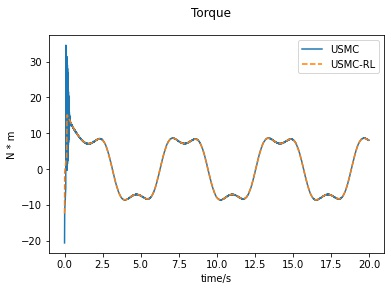

In [64]:
plt.suptitle('Torque')
plt.plot(time_list, torque_l2, label="USMC")
plt.plot(time_list, torque_l, label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.ylabel('N * m')
plt.legend()

In [65]:
# sum of output torque
np.sum(abs(np.array(torque_l2))), np.sum(abs(np.array(torque_l)))

(27659.317020467483, 27337.549973656794)

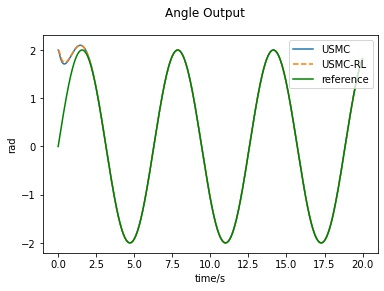

In [66]:
plt.suptitle('Angle Output')
plt.plot(time_list, th_list2, label="USMC")
plt.plot(time_list, th_list, label="USMC-RL", linestyle='dashed')
plt.plot(time_list, th_r, 'g', label="reference")
plt.xlabel('time/s')
plt.ylabel('rad')
plt.legend()

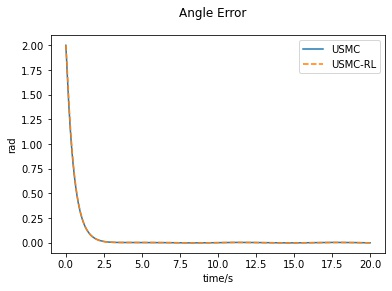

In [67]:
plt.suptitle('Angle Error')
plt.plot(time_list, np.array(th_list2) - np.array(th_r), label="USMC")
plt.plot(time_list, np.array(th_list) - np.array(th_r), label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.ylabel('rad')
plt.legend()

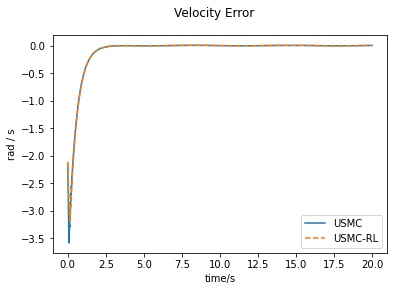

In [68]:
plt.suptitle('Velocity Error')
plt.plot(time_list, np.array(thdot_list2) - np.array(thdot_r), label="USMC")
plt.plot(time_list, np.array(thdot_list) - np.array(thdot_r), label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.ylabel('rad / s')
plt.legend()

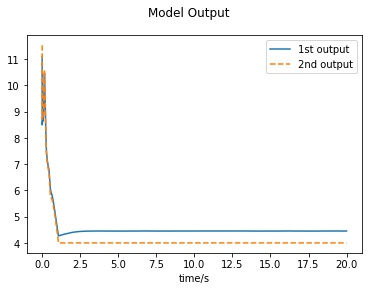

In [69]:
action_1 = []
action_2 = []
for i in range(len(action_l)):
    action_1.append(action_l[i][0])
    action_2.append(action_l[i][1])

plt.suptitle('Model Output')
plt.plot(time_list, action_1, label="1st output")
plt.plot(time_list, action_2, label="2nd output", linestyle='dashed')
plt.xlabel('time/s')
plt.legend()

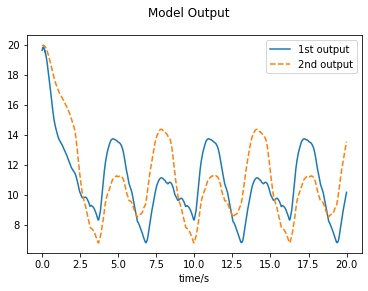

In [70]:
action_1 = []
action_2 = []
for i in range(len(action_l2)):
    action_1.append(action_l2[i][0])
    action_2.append(action_l2[i][1])

plt.suptitle('Model Output')
plt.plot(time_list, action_1, label="1st output")
plt.plot(time_list, action_2, label="2nd output", linestyle='dashed')
plt.xlabel('time/s')
plt.legend()

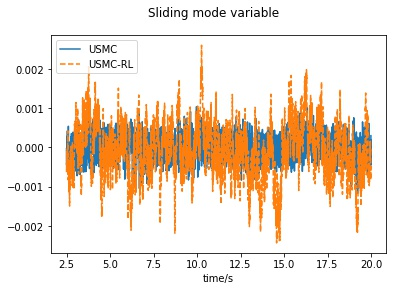

In [71]:
plt.suptitle('Sliding mode variable')
plt.plot(time_list[500:], s_l2[500:], label="USMC")
plt.plot(time_list[500:], s_l[500:], label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.legend()

In [72]:
np.sum(abs(np.array(s_l[:]))), np.sum(abs(np.array(s_l2[:])))

(34.024173243708574, 17.59776598343013)

# save model

In [35]:
# agent.actor.save('2022-02-02-1-Noise-Sine-SMC-actor.hdf5')
# agent.actor_target.save('2022-02-02-1-Noise-Sine-SMC-actor_target.hdf5')
# agent.critic.save('2022-02-02-1-Noise-Sine-SMC-critic.hdf5')
# agent.critic_target.save('2022-02-02-1-Noise-Sine-SMC-critic_target.hdf5')

# Visualization

In [45]:
value0 = np.zeros((200, 200))
value1 = np.zeros((200, 200))
for i in range(0, 200):
    for j in range(0, 200):
        value = agent.get_action(np.array([0, 0, float((i-100)/50), float((j-100)/50)]), greedy=True).numpy()
        #print(i, j)
        value0[i][j] = value[0]
        value1[i][j] = value[0]
        # ax.scatter3D(i, j, value[i][j], c=value[i][j], cmap='Greens');

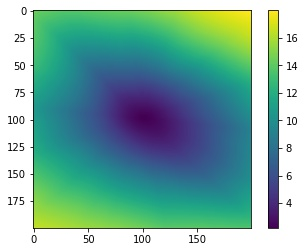

In [46]:
plt.imshow(value0)
plt.colorbar()

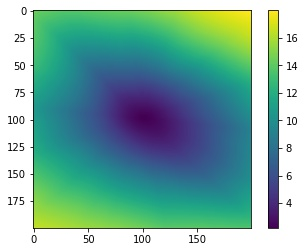

In [47]:
plt.imshow(value1)
plt.colorbar()

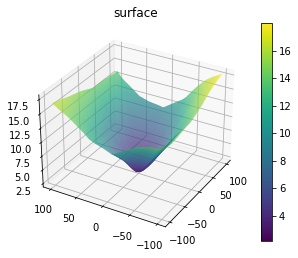

In [48]:
x = np.linspace(-100, 100, 200)
y = np.linspace(-100, 100, 200)
X, Y = np.meshgrid(x, y)
Z = value0
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.view_init(30, 210)

C = np.linspace(np.min(value0), np.max(value0), 40000).reshape(value1.shape)
scamap = plt.cm.ScalarMappable(cmap='viridis')
fcolors = scamap.to_rgba(C)


#scamap = plt.cm.ScalarMappable(cmap='viridis')

# fcolors = scamap.to_rgba(C)
# ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='viridis')
fig.colorbar(scamap)

plt.show()

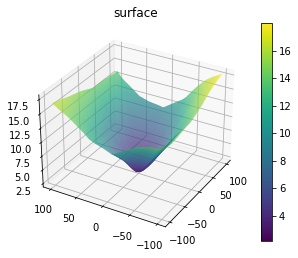

In [49]:
x = np.linspace(-100, 100, 200)
y = np.linspace(-100, 100, 200)
X, Y = np.meshgrid(x, y)
Z = value1
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.view_init(30, 210)

C = np.linspace(np.min(value1), np.max(value1), 40000).reshape(value1.shape)
scamap = plt.cm.ScalarMappable(cmap='viridis')
fcolors = scamap.to_rgba(C)


#scamap = plt.cm.ScalarMappable(cmap='viridis')

# fcolors = scamap.to_rgba(C)
# ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='viridis')
fig.colorbar(scamap)

plt.show()

# combining U-model

In [7]:
import sympy
import copy
t3, s3 = sympy.symbols('t, s')

env = PendulumSMCEnv()
env.dt=0.005

th_r = []
thdot_r = []

# test
# agent.load()
th_list = []
thdot_list = []
action_l = []
torque_l = []
s_l = []
eth_list =[]
ethdot_list=[]

for episode in range(1):
    # state initialisation
    state = env.reset()
    env.state = np.array([2, 1, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    '''
        
    ############# Constant target angle
    target = np.array([1, 0])
    target0 = target[0]
    target1 = target[1]

    target0 = target0 / s3
    target1 = target1 / s3

    transfer = 25 / (s3**2 + 10 * s3 +25)
    target0 = sympy.Mul(target0, transfer)
    target1 = sympy.Mul(target1, transfer)
    itransfer0 = sympy.inverse_laplace_transform(target0, s3, t3)
    itransfer1 = sympy.inverse_laplace_transform(target1, s3, t3)
    #############################
    '''
    
    # Target specification
        
    ############# sine target angle
    target = np.array([2 * np.sin(0.5*step*env.dt), 1 * np.cos(0.5*step*env.dt)])
    target0 = 2 * 0.5 / (s3**2 + 0.25)
    target1 = s3 / (s3**2 + 0.25)
    itransfer0 = sympy.inverse_laplace_transform(2500/(100*s3**4+1000*s3**3+2525*s3**2+250*s3+625), s3, t3).evalf().simplify()
    itransfer1 = sympy.inverse_laplace_transform(2500*s3/(100*s3**4+1000*s3**3+2525*s3**2+250*s3+625), s3, t3).evalf().simplify()
        
        
    for step in range(10000):
        
        if step%100 == 0:
            print(step)
            
        noise = (np.random.random()-0.5) * 2 * 0.01

        
        
        #################################
        
        
        # get timie-domain value
        value0 = itransfer0.evalf(subs ={'t':env.dt*(step+1)})
        value1 = itransfer1.evalf(subs ={'t':env.dt*(step+1)})
        target = np.array([value0, value1])
    
    
    
        #target = np.array([0, 0])
        th_r.append(2 * np.sin(0.5*step*env.dt))
        thdot_r.append(1 * np.cos(0.5*step*env.dt))
        
        state, reward, done, info, torque, s = env.step(agent.get_action(state, greedy=True), target, 0)
        
        th_list.append(state[0])
        thdot_list.append(state[1])
        eth_list.append(state[2])
        ethdot_list.append(state[3])
        action_l.append(agent.get_action(state, greedy=True))
        torque_l.append(float(torque))
        s_l.append(float(s))
        
        episode_reward += reward
        if done:
            break
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    )

D:\Anaconda3\envs\tf-cpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
Testing  | Episode: 1/10  | Episode Reward: -17040.1960  | Running Time: 246.9011


# XAI Shap

In [6]:
import shap
X = []
y1 = []
y2 = []
for _ in range(5000):
    state = np.random.uniform(low=[-1.57,-1,-1.57,-1], high=[1.57,1,1.57,1], size=(4))
    # state[0] = np.random.uniform(low=-1.57, high=1.57)
    # state[1] = np.random.uniform(low=-10, high=10)
    #state[2] = np.random.uniform(low=-1.57, high=1.57)
    #state[0] = 0
    #state[1] = 0
    X.append(state)
    a1, a2 = agent.get_action(state, greedy=True)
    y1.append(a1.numpy())
    y2.append(a2.numpy())
X = np.array(X)

In [12]:
actor = tf.keras.models.load_model('2022-02-02-1-Noise-Sine-SMC-actor.hdf5', compile=False)
background = shap.sample(X, 300)
explainer = shap.DeepExplainer(actor, background)
shap_values = explainer.shap_values(np.array([[0,0,-1,-1]]))
# shap_values = explainer.shap_values(background)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [13]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0])

In [14]:
shap.initjs()
shap.force_plot(explainer.expected_value[1].numpy(), shap_values[1])

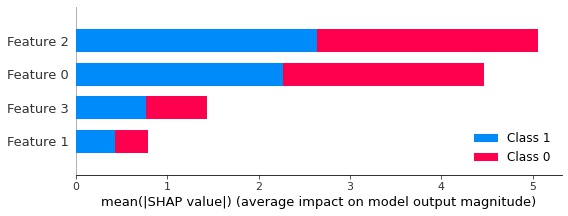

In [10]:
shap.summary_plot(shap_values, X, plot_type="bar")

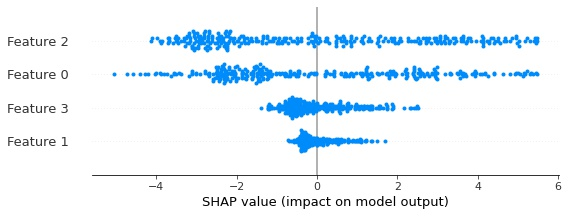

In [11]:
shap.summary_plot(shap_values[0], plot_type="dot")

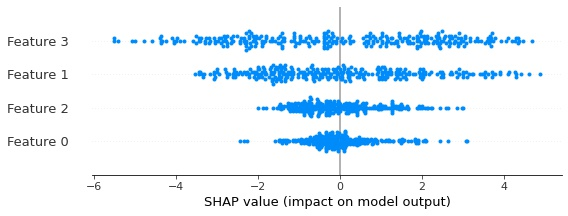

In [21]:
shap.summary_plot(shap_values[0], plot_type="dot")

In [263]:
X.mean(axis=0)

array([0.01538768, 0.03914362, 0.01549667, 0.00276462])

In [264]:
X.std(axis=0)

array([0.90224272, 2.8683172 , 0.90398016, 2.88674619])

In [265]:
X.max(axis=0)

array([1.56971739, 4.9987835 , 1.56991266, 4.99933946])

In [266]:
X.min(axis=0)

array([-1.56964623, -4.99991075, -1.56950032, -4.99935311])

# Fuzzy Logic

In [7]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl

In [7]:
error_range = np.arange(0,5,0.01,np.float32)
vel_error_range = np.arange(0,15,0.01,np.float32)

gain_range = np.arange(0,20,0.01,np.float32)
thick_range = np.arange(0,20,0.01,np.float32)

In [8]:
error = ctrl.Antecedent(error_range, 'error')

vel_error = ctrl.Antecedent(vel_error_range, 'vel_error')

gain = ctrl.Consequent(gain_range, 'gain')

thick = ctrl.Consequent(thick_range, 'thick')

In [67]:
# Here we use the convenience `automf` to populate the fuzzy variables with
# terms. The optional kwarg `names=` lets us specify the names of our Terms.
names = ['nb', 'ns', 'ze', 'ps', 'pb']
error.automf(names=names)
vel_error.automf(names=names)
gain.automf(names=names)
thick.automf(names=names)

"""
Define complex rules
--------------------
This system has a complicated, fully connected set of rules defined below.
"""
rule10 = ctrl.Rule(antecedent=((error['nb'] & vel_error['nb']) |
                              (error['ns'] & vel_error['nb']) |
                              (error['nb'] & vel_error['ns'])),
                  consequent=gain['nb'], label='rule1 nb')

rule11 = ctrl.Rule(antecedent=((error['nb'] & vel_error['ze']) |
                              (error['nb'] & vel_error['ps']) |
                              (error['ns'] & vel_error['ns']) |
                              (error['ns'] & vel_error['ze']) |
                              (error['ze'] & vel_error['ns']) |
                              (error['ze'] & vel_error['nb']) |
                              (error['ps'] & vel_error['nb'])),
                  consequent=gain['ns'], label='rule1 ns')

rule12 = ctrl.Rule(antecedent=((error['nb'] & vel_error['pb']) |
                              (error['ns'] & vel_error['ps']) |
                              (error['ze'] & vel_error['ze']) |
                              (error['ps'] & vel_error['ns']) |
                              (error['pb'] & vel_error['nb'])),
                  consequent=gain['ze'], label='rule1 ze')

rule13 = ctrl.Rule(antecedent=((error['ns'] & vel_error['pb']) |
                              (error['ze'] & vel_error['pb']) |
                              (error['ze'] & vel_error['ps']) |
                              (error['ps'] & vel_error['ps']) |
                              (error['ps'] & vel_error['ze']) |
                              (error['pb'] & vel_error['ze']) |
                              (error['pb'] & vel_error['ns'])),
                  consequent=gain['ps'], label='rule1 ps')

rule14 = ctrl.Rule(antecedent=((error['ps'] & vel_error['pb']) |
                              (error['pb'] & vel_error['pb']) |
                              (error['pb'] & vel_error['ps'])),
                  consequent=gain['pb'], label='rule1 pb')
#################################### 
rule20 = ctrl.Rule(antecedent=((error['nb'] & vel_error['nb']) |
                              (error['ns'] & vel_error['nb']) |
                              (error['nb'] & vel_error['ns'])),
                  consequent=thick['nb'], label='rule2 nb')

rule21 = ctrl.Rule(antecedent=((error['nb'] & vel_error['ze']) |
                              (error['nb'] & vel_error['ps']) |
                              (error['ns'] & vel_error['ns']) |
                              (error['ns'] & vel_error['ze']) |
                              (error['ze'] & vel_error['ns']) |
                              (error['ze'] & vel_error['nb']) |
                              (error['ps'] & vel_error['nb'])),
                  consequent=thick['ns'], label='rule2 ns')

rule22 = ctrl.Rule(antecedent=((error['nb'] & vel_error['pb']) |
                              (error['ns'] & vel_error['ps']) |
                              (error['ze'] & vel_error['ze']) |
                              (error['ps'] & vel_error['ns']) |
                              (error['pb'] & vel_error['nb'])),
                  consequent=thick['ze'], label='rule2 ze')

rule23 = ctrl.Rule(antecedent=((error['ns'] & vel_error['pb']) |
                              (error['ze'] & vel_error['pb']) |
                              (error['ze'] & vel_error['ps']) |
                              (error['ps'] & vel_error['ps']) |
                              (error['ps'] & vel_error['ze']) |
                              (error['pb'] & vel_error['ze']) |
                              (error['pb'] & vel_error['ns'])),
                  consequent=thick['ps'], label='rule2 ps')

rule24 = ctrl.Rule(antecedent=((error['ps'] & vel_error['pb']) |
                              (error['pb'] & vel_error['pb']) |
                              (error['pb'] & vel_error['ps'])),
                  consequent=thick['pb'], label='rule2 pb')


# 系统和运行环境初始化

system = ctrl.ControlSystem(rules=[rule10, rule11, rule12, rule13, rule14, rule20, rule21, rule22, rule23, rule24])

sim = ctrl.ControlSystemSimulation(system)


In [142]:
# 定义模糊集和其隶属度函数

error['N']=fuzz.trimf(error_range,[-5,-2.5,0])
error['M']=fuzz.trimf(error_range,[-2.5,0,2.5])
error['P']=fuzz.trimf(error_range,[0,2.5,5])

vel_error['N']=fuzz.trimf(vel_error_range,[-15,-7.5,0])
vel_error['M']=fuzz.trimf(vel_error_range,[-7.5,0,7.5])
vel_error['P']=fuzz.trimf(vel_error_range,[0,7.5,15])

gain['N']=fuzz.trimf(gain_range,[-20,-10,0])
gain['M']=fuzz.trimf(gain_range,[-10,0,10])
gain['P']=fuzz.trimf(gain_range,[0,10,20])

thick['N']=fuzz.trimf(thick_range,[-20,-10,0])
thick['M']=fuzz.trimf(thick_range,[-10,0,10])
thick['P']=fuzz.trimf(thick_range,[0,10,20])

'''
##########################################################
names = ['N', 'M', 'P']
error.automf(names=names)
vel_error.automf(names=names)
gain.automf(names=names)
thick.automf(names=names)


##########################################################
error['N']=fuzz.gaussmf(error_range,-2.5, 1)
error['M']=fuzz.gaussmf(error_range,0, 1)
error['P']=fuzz.gaussmf(error_range,2.5, 1)

vel_error['N']=fuzz.gaussmf(vel_error_range,-7.5, 2)
vel_error['M']=fuzz.gaussmf(vel_error_range,0, 2)
vel_error['P']=fuzz.gaussmf(vel_error_range,7.5, 3)

gain['N']=fuzz.gaussmf(gain_range,-10, 4)
gain['M']=fuzz.gaussmf(gain_range,0, 4)
gain['P']=fuzz.gaussmf(gain_range,10, 4)

thick['N']=fuzz.gaussmf(gain_range,-10, 4)
thick['M']=fuzz.gaussmf(gain_range,0, 4)
thick['P']=fuzz.gaussmf(gain_range,10, 4)
'''

# 设定输出解模糊方法——质心解模糊方式
gain.defuzzify_method='centroid'
thick.defuzzify_method='centroid'

In [143]:
# 输出为N的规则

rule10 = ctrl.Rule(antecedent=((error['N'] & vel_error['N']) |

                              (error['M'] & vel_error['N']) ),

                  consequent=gain['N'], label='rule1 N')

# 输出为M的规则

rule11 = ctrl.Rule(antecedent=((error['P'] & vel_error['N']) |

                              (error['N'] & vel_error['M']) |

                              (error['M'] & vel_error['M']) |

                              (error['P'] & vel_error['M']) |

                              (error['N'] & vel_error['P']) ),

                  consequent=gain['M'], label='rule1 M')

# 输出为P的规则

rule12 = ctrl.Rule(antecedent=((error['M'] & vel_error['P']) |

                              (error['P'] & vel_error['P']) ),

                  consequent=gain['P'], label='rule1 P')


# 输出为N的规则

rule20 = ctrl.Rule(antecedent=((error['N'] & vel_error['N']) |

                              (error['M'] & vel_error['N']) ),

                  consequent=thick['N'], label='rule2 N')

# 输出为M的规则

rule21 = ctrl.Rule(antecedent=((error['P'] & vel_error['N']) |

                              (error['N'] & vel_error['M']) |

                              (error['M'] & vel_error['M']) |

                              (error['P'] & vel_error['M']) |

                              (error['N'] & vel_error['P']) ),

                  consequent=thick['M'], label='rule2 M')

# 输出为P的规则

rule22 = ctrl.Rule(antecedent=((error['M'] & vel_error['P']) |

                              (error['P'] & vel_error['P']) ),

                  consequent=thick['P'], label='rule2 P')


# 系统和运行环境初始化

system = ctrl.ControlSystem(rules=[rule10, rule11, rule12, rule20, rule21, rule22])

sim = ctrl.ControlSystemSimulation(system)


In [147]:
sim.input['error'] = 5

sim.input['vel_error'] = 15

sim.compute()   # 运行系统

output_gain = sim.output['gain']
output_thick = sim.output['thick']

 

# 打印输出结果

print(output_gain, output_thick)

9.99812460528309 9.99812460528309


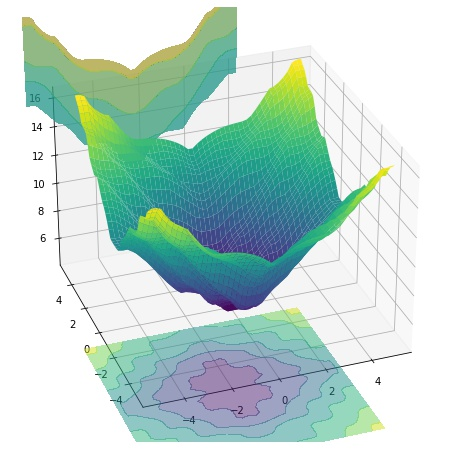

In [62]:
"""
View the control space
----------------------
With helpful use of Matplotlib and repeated simulations, we can observe what
the entire control system surface looks like in three dimensions!
"""
# We can simulate at higher resolution with full accuracy
upsampled = np.linspace(-5, 5, 50)
x, y = np.meshgrid(upsampled, upsampled)
z1 = np.zeros_like(x)
z2 = np.zeros_like(x)

# Loop through the system 21*21 times to collect the control surface
for i in range(50):
    for j in range(50):
        sim.input['error'] = abs(x[i, j])
        sim.input['vel_error'] = abs(y[i, j])
        sim.compute()
        z1[i, j] = sim.output['gain']
        z2[i, j] = sim.output['thick']

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt  # noqa: E402

# Required for 3D plotting
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401,E402

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z1, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z1, zdir='z', offset=-2, cmap='viridis', alpha=0.5)
# cset = ax.contourf(x, y, z1, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z1, zdir='y', offset=13, cmap='viridis', alpha=0.5)

ax.view_init(30, 250)

# RL vs fuzzy

In [63]:
env = PendulumSMCEnv()
# sampling time
env.dt=0.005

th_r = []
thdot_r = []

# test
th_list = []
thdot_list = []
action_l = []
torque_l = []
s_l = []
eth_list =[]
ethdot_list=[]
time_list = []

for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # RL-SMC
    for step in range(4000):
        noise = (np.random.random()-0.5) * 0.2
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        # target = np.array([0, 0, 0])
       
        
        th_r.append(target[0])
        thdot_r.append(target[1])
        
        sim.input['error'] = abs(state[-2])

        sim.input['vel_error'] = abs(state[-1])

        sim.compute()   # 运行系统

        output_gain = sim.output['gain']
        output_thick = sim.output['thick']
        
        action = [output_gain, output_thick]

        state, reward, done, info, torque, s = env.step(action, target, noise)
        
        th_list.append(state[0])
        thdot_list.append(state[1])
        eth_list.append(state[2])
        ethdot_list.append(state[3])
        action_l.append(action)
        torque_l.append(float(torque))
        s_l.append(float(s))
        time_list.append(step*env.dt)
        
        episode_reward += reward
        if done:
            break
    '''
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    )
    '''
    print(episode_reward)

th_list2 = []
thdot_list2 = []
action_l2 = []
torque_l2 = []
s_l2 = []
eth_list2 =[]
ethdot_list2 =[]
for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # pure SMC
    for step in range(4000):
        # env.render()
        noise = (np.random.random()-0.5) * 0.2
        
        # Target specification
        target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        # target = np.array([0, 0, 0])

        state, reward, done, info, torque, s = env.step(agent.get_action(state, greedy=True), target, noise)
        # state, reward, done, info, torque, s = env.step([100000000000, 6.05052635], target, noise)
        # state, reward, done, info, torque, s = env.step([20, 20], target, noise) # same cost with training
        # state, reward, done, info, torque, s = env.step([13.43, 20], target, noise) # cost = sum abs(s)
        
        
        th_list2.append(state[0])
        thdot_list2.append(state[1])
        eth_list2.append(state[2])
        ethdot_list2.append(state[3])
        action_l2.append(agent.get_action(state, greedy=True))
        torque_l2.append(float(torque))
        s_l2.append(float(s))
        
        episode_reward += reward
        if done:
            break
    '''
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    
    )
    '''
    print(episode_reward)


D:\Anaconda3\envs\tf-cpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


-2388.291865390176
-4029.6956717967987


# PSO fuzzy

In [9]:
import sko

In [15]:
def demo_func(x):
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12 = x
    x1, x2, x3, x4, x5 = sorted([x1, x2, x3, x4, x5])
    x6, x7, x8, x9, x10 = sorted([x6, x7, x8, x9, x10])
    
    # 定义模糊集和其隶属度函数

    error['nb']=fuzz.trimf(error_range,[x1-x11,x1,x1+x11])
    error['ns']=fuzz.trimf(error_range,[x2-x11,x2,x2+x11])
    error['ze']=fuzz.trimf(error_range,[x3-x11,x3,x3+x11])
    error['ps']=fuzz.trimf(error_range,[x4-x11,x4,x4+x11])
    error['pb']=fuzz.trimf(error_range,[x5-x11,x5,x5+x11])

    vel_error['nb']=fuzz.trimf(vel_error_range,[x4-x12,x6,x4+x12])
    vel_error['ns']=fuzz.trimf(vel_error_range,[x5-x12,x7,x5+x12])
    vel_error['ze']=fuzz.trimf(vel_error_range,[x6-x12,x8,x6+x12])
    vel_error['ps']=fuzz.trimf(vel_error_range,[x5-x12,x9,x5+x12])
    vel_error['pb']=fuzz.trimf(vel_error_range,[x6-x12,x10,x6+x12])

    gain['N']=fuzz.trimf(gain_range,[-20,-10,0])
    gain['M']=fuzz.trimf(gain_range,[-10,0,10])
    gain['P']=fuzz.trimf(gain_range,[0,10,20])

    thick['N']=fuzz.trimf(thick_range,[-20,-10,0])
    thick['M']=fuzz.trimf(thick_range,[-10,0,10])
    thick['P']=fuzz.trimf(thick_range,[0,10,20])

    
    """
    Define complex rules
    --------------------
    This system has a complicated, fully connected set of rules defined below.
    """
    rule10 = ctrl.Rule(antecedent=((error['nb'] & vel_error['nb']) |
                                  (error['ns'] & vel_error['nb']) |
                                  (error['nb'] & vel_error['ns'])),
                      consequent=gain['nb'], label='rule1 nb')

    rule11 = ctrl.Rule(antecedent=((error['nb'] & vel_error['ze']) |
                                  (error['nb'] & vel_error['ps']) |
                                  (error['ns'] & vel_error['ns']) |
                                  (error['ns'] & vel_error['ze']) |
                                  (error['ze'] & vel_error['ns']) |
                                  (error['ze'] & vel_error['nb']) |
                                  (error['ps'] & vel_error['nb'])),
                      consequent=gain['ns'], label='rule1 ns')

    rule12 = ctrl.Rule(antecedent=((error['nb'] & vel_error['pb']) |
                                  (error['ns'] & vel_error['ps']) |
                                  (error['ze'] & vel_error['ze']) |
                                  (error['ps'] & vel_error['ns']) |
                                  (error['pb'] & vel_error['nb'])),
                      consequent=gain['ze'], label='rule1 ze')

    rule13 = ctrl.Rule(antecedent=((error['ns'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ns'])),
                      consequent=gain['ps'], label='rule1 ps')

    rule14 = ctrl.Rule(antecedent=((error['ps'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['ps'])),
                      consequent=gain['pb'], label='rule1 pb')
    #################################### 
    rule20 = ctrl.Rule(antecedent=((error['nb'] & vel_error['nb']) |
                                  (error['ns'] & vel_error['nb']) |
                                  (error['nb'] & vel_error['ns'])),
                      consequent=thick['nb'], label='rule2 nb')

    rule21 = ctrl.Rule(antecedent=((error['nb'] & vel_error['ze']) |
                                  (error['nb'] & vel_error['ps']) |
                                  (error['ns'] & vel_error['ns']) |
                                  (error['ns'] & vel_error['ze']) |
                                  (error['ze'] & vel_error['ns']) |
                                  (error['ze'] & vel_error['nb']) |
                                  (error['ps'] & vel_error['nb'])),
                      consequent=thick['ns'], label='rule2 ns')

    rule22 = ctrl.Rule(antecedent=((error['nb'] & vel_error['pb']) |
                                  (error['ns'] & vel_error['ps']) |
                                  (error['ze'] & vel_error['ze']) |
                                  (error['ps'] & vel_error['ns']) |
                                  (error['pb'] & vel_error['nb'])),
                      consequent=thick['ze'], label='rule2 ze')

    rule23 = ctrl.Rule(antecedent=((error['ns'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ns'])),
                      consequent=thick['ps'], label='rule2 ps')

    rule24 = ctrl.Rule(antecedent=((error['ps'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['ps'])),
                      consequent=thick['pb'], label='rule2 pb')


    # 系统和运行环境初始化

    system = ctrl.ControlSystem(rules=[rule10, rule11, rule12, rule13, rule14, rule20, rule21, rule22, rule23, rule24])

    sim = ctrl.ControlSystemSimulation(system)

    
    
    
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # RL-SMC
    for step in range(4000):
        noise = (np.random.random()-0.5) * 2
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        # target = np.array([0, 0, 0])

        
        sim.input['error'] = abs(state[-2])

        sim.input['vel_error'] = abs(state[-1])
        
        try:
            sim.compute()   # 运行系统

            output_gain = sim.output['gain']
            output_thick = sim.output['thick']
        except:
            output_gain = 0
            output_thick = 0
        
        action = [output_gain, output_thick]

        state, reward, done, info, torque, s = env.step(action, target, noise)
        episode_reward += reward
        
    return episode_reward

In [16]:
from sko.PSO import PSO

error_range = np.arange(0,5,0.01,np.float32)
vel_error_range = np.arange(0,15,0.01,np.float32)

gain_range = np.arange(0,20,0.01,np.float32)
thick_range = np.arange(0,20,0.01,np.float32)

error = ctrl.Antecedent(error_range, 'error')
vel_error = ctrl.Antecedent(vel_error_range, 'vel_error')
gain = ctrl.Consequent(gain_range, 'gain')
thick = ctrl.Consequent(thick_range, 'thick')


pso = PSO(func=demo_func, dim=12, pop=40, max_iter=20, lb=[-5,-5,-5,-5,-5,-15,-15,-15,-15,-15, 0, 0], ub=[5,5,5,5,5,15,15,15,15,15,5,15], w=0.8, c1=0.5, c2=0.5)
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

AssertionError: abc requires the three elements a <= b <= c.

In [23]:
def demo_func(x):
    x1,x2,x3,x4,x5,x6,x7,x8 = x
    x1, x2, x3 = sorted([x1, x2, x3])
    x4, x5, x6 = sorted([x4, x5, x6])
    
    # 定义模糊集和其隶属度函数

    error['N']=fuzz.trimf(error_range,[x1-x7,x1,x1+x7])
    error['M']=fuzz.trimf(error_range,[x2-x7,x2,x2+x7])
    error['P']=fuzz.trimf(error_range,[x3-x7,x3,x3+x7])

    vel_error['N']=fuzz.trimf(vel_error_range,[x4-x8,x4,x4+x8])
    vel_error['M']=fuzz.trimf(vel_error_range,[x5-x8,x5,x5+x8])
    vel_error['P']=fuzz.trimf(vel_error_range,[x6-x8,x6,x6+x8])

    gain['N']=fuzz.trimf(gain_range,[0,5,10])
    gain['M']=fuzz.trimf(gain_range,[5,10,15])
    gain['P']=fuzz.trimf(gain_range,[10,15,20])

    thick['N']=fuzz.trimf(thick_range,[0,5,10])
    thick['M']=fuzz.trimf(thick_range,[5,10,15])
    thick['P']=fuzz.trimf(thick_range,[10,15,20])

    # 输出为N的规则

    rule10 = ctrl.Rule(antecedent=((error['N'] & vel_error['N']) |

                                  (error['M'] & vel_error['N']) ),

                      consequent=gain['N'], label='rule1 N')

    # 输出为M的规则

    rule11 = ctrl.Rule(antecedent=((error['P'] & vel_error['N']) |

                                  (error['N'] & vel_error['M']) |

                                  (error['M'] & vel_error['M']) |

                                  (error['P'] & vel_error['M']) |

                                  (error['N'] & vel_error['P']) ),

                      consequent=gain['M'], label='rule1 M')

    # 输出为P的规则

    rule12 = ctrl.Rule(antecedent=((error['M'] & vel_error['P']) |

                                  (error['P'] & vel_error['P']) ),

                      consequent=gain['P'], label='rule1 P')


    # 输出为N的规则

    rule20 = ctrl.Rule(antecedent=((error['N'] & vel_error['N']) |

                                  (error['M'] & vel_error['N']) ),

                      consequent=thick['N'], label='rule2 N')

    # 输出为M的规则

    rule21 = ctrl.Rule(antecedent=((error['P'] & vel_error['N']) |

                                  (error['N'] & vel_error['M']) |

                                  (error['M'] & vel_error['M']) |

                                  (error['P'] & vel_error['M']) |

                                  (error['N'] & vel_error['P']) ),

                      consequent=thick['M'], label='rule2 M')

    # 输出为P的规则

    rule22 = ctrl.Rule(antecedent=((error['M'] & vel_error['P']) |

                                  (error['P'] & vel_error['P']) ),

                      consequent=thick['P'], label='rule2 P')


    # 系统和运行环境初始化

    system = ctrl.ControlSystem(rules=[rule10, rule11, rule12, rule20, rule21, rule22])

    sim = ctrl.ControlSystemSimulation(system)

    
    
    
    
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # SMC
    for step in range(4000):
        noise = (np.random.random()-0.5) * 2
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        # target = np.array([0, 0, 0])
        
        sim.input['error'] = abs(state[-2])

        sim.input['vel_error'] = abs(state[-1])
        
        try:
            sim.compute()   # 运行系统

            output_gain = sim.output['gain']
            output_thick = sim.output['thick']
        except:
            output_gain = 0
            output_thick = 0
        
        action = [output_gain, output_thick]

        state, reward, done, info, torque, s = env.step(action, target, noise)
        episode_reward += abs(s)

    return - episode_reward

In [21]:
from sko.PSO import PSO

error_range = np.arange(0,5,0.01,np.float32)
vel_error_range = np.arange(0,15,0.01,np.float32)

gain_range = np.arange(0,20,0.01,np.float32)
thick_range = np.arange(0,20,0.01,np.float32)

error = ctrl.Antecedent(error_range, 'error')
vel_error = ctrl.Antecedent(vel_error_range, 'vel_error')
gain = ctrl.Consequent(gain_range, 'gain')
thick = ctrl.Consequent(thick_range, 'thick')


pso = PSO(func=demo_func, dim=8, pop=5, max_iter=20, lb=[0,0,0,0,0,0, 0, 0], ub=[5,5,5,15,15,15,5,10], w=0.8, c1=0.5, c2=0.5)
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

best_x is  [0.16940156 0.         4.68787534 0.         0.         0.
 3.83099766 5.07629215] best_y is [-2895.46074945]


In [24]:
sim = demo_func([0.16940156,0,4.68787534,0,0,0,3.83099766,5.07629215])

# fuzzy bayesian opt

In [20]:
def black_box_function(x1,x2,x3,x4,x5,x6,x7,x8):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """

    x1, x2, x3 = sorted([x1, x2, x3])
    x4, x5, x6 = sorted([x4, x5, x6])
    
    # 定义模糊集和其隶属度函数

    error['N']=fuzz.trimf(error_range,[x1-x7,x1,x1+x7])
    error['M']=fuzz.trimf(error_range,[x2-x7,x2,x2+x7])
    error['P']=fuzz.trimf(error_range,[x3-x7,x3,x3+x7])

    vel_error['N']=fuzz.trimf(vel_error_range,[x4-x8,x4,x4+x8])
    vel_error['M']=fuzz.trimf(vel_error_range,[x5-x8,x5,x5+x8])
    vel_error['P']=fuzz.trimf(vel_error_range,[x6-x8,x6,x6+x8])

    gain['N']=fuzz.trimf(gain_range,[0,5,10])
    gain['M']=fuzz.trimf(gain_range,[5,10,15])
    gain['P']=fuzz.trimf(gain_range,[10,15,20])

    thick['N']=fuzz.trimf(thick_range,[0,5,10])
    thick['M']=fuzz.trimf(thick_range,[5,10,15])
    thick['P']=fuzz.trimf(thick_range,[10,15,20])

    # 输出为N的规则

    rule10 = ctrl.Rule(antecedent=((error['N'] & vel_error['N']) |

                                  (error['M'] & vel_error['N']) ),

                      consequent=gain['N'], label='rule1 N')

    # 输出为M的规则

    rule11 = ctrl.Rule(antecedent=((error['P'] & vel_error['N']) |

                                  (error['N'] & vel_error['M']) |

                                  (error['M'] & vel_error['M']) |

                                  (error['P'] & vel_error['M']) |

                                  (error['N'] & vel_error['P']) ),

                      consequent=gain['M'], label='rule1 M')

    # 输出为P的规则

    rule12 = ctrl.Rule(antecedent=((error['M'] & vel_error['P']) |

                                  (error['P'] & vel_error['P']) ),

                      consequent=gain['P'], label='rule1 P')


    # 输出为N的规则

    rule20 = ctrl.Rule(antecedent=((error['N'] & vel_error['N']) |

                                  (error['M'] & vel_error['N']) ),

                      consequent=thick['N'], label='rule2 N')

    # 输出为M的规则

    rule21 = ctrl.Rule(antecedent=((error['P'] & vel_error['N']) |

                                  (error['N'] & vel_error['M']) |

                                  (error['M'] & vel_error['M']) |

                                  (error['P'] & vel_error['M']) |

                                  (error['N'] & vel_error['P']) ),

                      consequent=thick['M'], label='rule2 M')

    # 输出为P的规则

    rule22 = ctrl.Rule(antecedent=((error['M'] & vel_error['P']) |

                                  (error['P'] & vel_error['P']) ),

                      consequent=thick['P'], label='rule2 P')


    # 系统和运行环境初始化

    system = ctrl.ControlSystem(rules=[rule10, rule11, rule12, rule20, rule21, rule22])

    sim = ctrl.ControlSystemSimulation(system)

    
    
    
    
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # SMC
    for step in range(4000):
        noise = (np.random.random()-0.5) * 2
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        # target = np.array([0, 0, 0])
        
        sim.input['error'] = abs(state[-2])

        sim.input['vel_error'] = abs(state[-1])
        
        try:
            sim.compute()   # 运行系统

            output_gain = sim.output['gain']
            output_thick = sim.output['thick']
        except:
            output_gain = 0
            output_thick = 0
        
        action = [output_gain, output_thick]

        state, reward, done, info, torque, s = env.step(action, target, noise)
        episode_reward += abs(s)
    return sim

In [19]:
from bayes_opt import BayesianOptimization

error_range = np.arange(0,5,0.01,np.float32)
vel_error_range = np.arange(0,5,0.01,np.float32)

gain_range = np.arange(0,20,0.01,np.float32)
thick_range = np.arange(0,20,0.01,np.float32)

error = ctrl.Antecedent(error_range, 'error')
vel_error = ctrl.Antecedent(vel_error_range, 'vel_error')
gain = ctrl.Consequent(gain_range, 'gain')
thick = ctrl.Consequent(thick_range, 'thick')


x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
# Bounded region of parameter space
pbounds = {'x1': (0, 5),'x2': (0, 5),'x3': (0, 5),'x4': (0, 5),'x5': (0, 5),'x6': (0, 5),'x7': (0, 3),'x8': (0, 3)}
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=100,
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |
-------------------------------------------------------------------------------------------------------------------------
|  2        | -226.3    |  1.984    |  2.694    |  2.096    |  10.28    |  3.067    |  13.17    |  0.08216  |  6.034    |
|  6        | -199.0    |  0.0      |  0.0      |  5.0      |  1.627    |  15.0     |  15.0     |  0.0      |  9.0      |
|  10       | -198.7    |  0.0      |  5.0      |  0.0      |  8.027    |  15.0     |  15.0     |  0.0      |  9.0      |
|  12       | -194.8    |  0.0      |  5.0      |  5.0      |  15.0     |  15.0     |  4.272    |  0.0      |  9.0      |
|  15       | -123.2    |  5.0      |  0.0      |  5.0      |  15.0     |  15.0     |  0.0      |  3.0      |  9.0      |
|  79       | -122.3    |  0.0      |  5.0      |  5.0      |  0.0      |  15.0     |  15.0     |  3.0      |  9.0      |
|  93       | -122.3    

In [8]:
def black_box_function(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    x1, x2, x3, x4, x5 = sorted([x1, x2, x3, x4, x5])
    x6, x7, x8, x9, x10 = sorted([x6, x7, x8, x9, x10])
    
    # 定义模糊集和其隶属度函数

    error['nb']=fuzz.trimf(error_range,[x1-x11,x1,x1+x11])
    error['ns']=fuzz.trimf(error_range,[x2-x11,x2,x2+x11])
    error['ze']=fuzz.trimf(error_range,[x3-x11,x3,x3+x11])
    error['ps']=fuzz.trimf(error_range,[x4-x11,x4,x4+x11])
    error['pb']=fuzz.trimf(error_range,[x5-x11,x5,x5+x11])

    vel_error['nb']=fuzz.trimf(vel_error_range,[x6-x12,x6,x6+x12])
    vel_error['ns']=fuzz.trimf(vel_error_range,[x7-x12,x7,x7+x12])
    vel_error['ze']=fuzz.trimf(vel_error_range,[x8-x12,x8,x8+x12])
    vel_error['ps']=fuzz.trimf(vel_error_range,[x9-x12,x9,x9+x12])
    vel_error['pb']=fuzz.trimf(vel_error_range,[x10-x12,x10,x10+x12])

    gain['nb']=fuzz.trimf(gain_range,[1,4,7])
    gain['ns']=fuzz.trimf(gain_range,[5,8,11])
    gain['ze']=fuzz.trimf(gain_range,[9,12,15])
    gain['ps']=fuzz.trimf(gain_range,[13,16,19])
    gain['pb']=fuzz.trimf(gain_range,[17,20,20])

    thick['nb']=fuzz.trimf(thick_range,[1,4,7])
    thick['ns']=fuzz.trimf(thick_range,[5,8,11])
    thick['ze']=fuzz.trimf(thick_range,[9,12,15])
    thick['ps']=fuzz.trimf(thick_range,[13,16,19])
    thick['pb']=fuzz.trimf(thick_range,[17,20,20])

    
    """
    Define complex rules
    --------------------
    This system has a complicated, fully connected set of rules defined below.
    """
    rule10 = ctrl.Rule(antecedent=((error['nb'] & vel_error['nb']) |
                                  (error['ns'] & vel_error['nb']) |
                                  (error['nb'] & vel_error['ns'])),
                      consequent=gain['nb'], label='rule1 nb')

    rule11 = ctrl.Rule(antecedent=((error['nb'] & vel_error['ze']) |
                                  (error['nb'] & vel_error['ps']) |
                                  (error['ns'] & vel_error['ns']) |
                                  (error['ns'] & vel_error['ze']) |
                                  (error['ze'] & vel_error['ns']) |
                                  (error['ze'] & vel_error['nb']) |
                                  (error['ps'] & vel_error['nb'])),
                      consequent=gain['ns'], label='rule1 ns')

    rule12 = ctrl.Rule(antecedent=((error['nb'] & vel_error['pb']) |
                                  (error['ns'] & vel_error['ps']) |
                                  (error['ze'] & vel_error['ze']) |
                                  (error['ps'] & vel_error['ns']) |
                                  (error['pb'] & vel_error['nb'])),
                      consequent=gain['ze'], label='rule1 ze')

    rule13 = ctrl.Rule(antecedent=((error['ns'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ns'])),
                      consequent=gain['ps'], label='rule1 ps')

    rule14 = ctrl.Rule(antecedent=((error['ps'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['ps'])),
                      consequent=gain['pb'], label='rule1 pb')
    #################################### 
    rule20 = ctrl.Rule(antecedent=((error['nb'] & vel_error['nb']) |
                                  (error['ns'] & vel_error['nb']) |
                                  (error['nb'] & vel_error['ns'])),
                      consequent=thick['nb'], label='rule2 nb')

    rule21 = ctrl.Rule(antecedent=((error['nb'] & vel_error['ze']) |
                                  (error['nb'] & vel_error['ps']) |
                                  (error['ns'] & vel_error['ns']) |
                                  (error['ns'] & vel_error['ze']) |
                                  (error['ze'] & vel_error['ns']) |
                                  (error['ze'] & vel_error['nb']) |
                                  (error['ps'] & vel_error['nb'])),
                      consequent=thick['ns'], label='rule2 ns')

    rule22 = ctrl.Rule(antecedent=((error['nb'] & vel_error['pb']) |
                                  (error['ns'] & vel_error['ps']) |
                                  (error['ze'] & vel_error['ze']) |
                                  (error['ps'] & vel_error['ns']) |
                                  (error['pb'] & vel_error['nb'])),
                      consequent=thick['ze'], label='rule2 ze')

    rule23 = ctrl.Rule(antecedent=((error['ns'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ns'])),
                      consequent=thick['ps'], label='rule2 ps')

    rule24 = ctrl.Rule(antecedent=((error['ps'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['ps'])),
                      consequent=thick['pb'], label='rule2 pb')


    # 系统和运行环境初始化

    system = ctrl.ControlSystem(rules=[rule10, rule11, rule12, rule13, rule14, rule20, rule21, rule22, rule23, rule24])

    sim = ctrl.ControlSystemSimulation(system)

    
    
    
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # RL-SMC
    for step in range(4000):
        noise = (np.random.random()-0.5) * 2
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        # target = np.array([0, 0, 0])

        
        sim.input['error'] = abs(state[-2])

        sim.input['vel_error'] = abs(state[-1])
        
        try:
            sim.compute()   # 运行系统

            output_gain = sim.output['gain']
            output_thick = sim.output['thick']
        except:
            output_gain = 0
            output_thick = 0
        
        action = [output_gain, output_thick]

        state, reward, done, info, torque, s = env.step(action, target, noise)
        episode_reward += abs(s)
        
    return - episode_reward

In [9]:
from bayes_opt import BayesianOptimization

error_range = np.arange(0,5,0.01,np.float32)
vel_error_range = np.arange(0,5,0.01,np.float32)

gain_range = np.arange(0,20,0.01,np.float32)
thick_range = np.arange(0,20,0.01,np.float32)

error = ctrl.Antecedent(error_range, 'error')
vel_error = ctrl.Antecedent(vel_error_range, 'vel_error')
gain = ctrl.Consequent(gain_range, 'gain')
thick = ctrl.Consequent(thick_range, 'thick')



# Bounded region of parameter space
pbounds = {'x1': (0, 5),'x2': (0, 5),'x3': (0, 5),'x4': (0, 5),'x5': (0, 5),'x6': (0, 5),'x7': (0, 5),'x8': (0, 5),'x9': (0, 5),'x10': (0, 5),'x11': (0, 3),'x12': (0, 3)}
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=100,
)

|   iter    |  target   |    x1     |    x10    |    x11    |    x12    |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |    x9     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -235.9    |  2.085    |  3.602    |  0.000343 |  0.907    |  0.7338   |  0.4617   |  0.9313   |  1.728    |  1.984    |  2.694    |  2.096    |  3.426    |
|  2        | -218.9    |  1.022    |  4.391    |  0.08216  |  2.011    |  2.087    |  2.793    |  0.7019   |  0.9905   |  4.004    |  4.841    |  1.567    |  3.462    |
|  3        | -117.8    |  0.828    |  4.49     |  0.3966   |  2.493    |  2.676    |  2.724    |  0.3743   |  2.45     |  4.146    |  4.716    |  0.2244   |  3.933    |
|  4        | -113.4    |  1.42     |  4.937    |  2.969    |  0.8105   |  4.525    |  2.3      |  4.946    |  3.582    |  1.957    |  1.414    |  4.1

|  29       | -113.6    |  2.359    |  5.0      |  1.79     |  1.015    |  2.672    |  5.0      |  0.0      |  5.0      |  4.922    |  1.945    |  0.0      |  3.309    |
|  30       | -224.2    |  2.163    |  5.0      |  2.025    |  0.876    |  2.758    |  5.0      |  0.0      |  5.0      |  5.0      |  5.0      |  3.033    |  3.456    |
|  31       | -118.4    |  4.735    |  5.0      |  0.1648   |  2.442    |  2.263    |  5.0      |  0.0      |  5.0      |  3.602    |  4.141    |  0.0      |  2.331    |
|  32       | -225.0    |  2.124    |  5.0      |  0.01469  |  0.0      |  0.6364   |  5.0      |  0.0      |  5.0      |  3.246    |  3.922    |  0.0      |  1.426    |
|  33       | -112.8    |  2.411    |  5.0      |  1.81     |  3.0      |  5.0      |  5.0      |  0.0      |  5.0      |  3.324    |  3.425    |  0.0      |  2.223    |
|  34       | -115.1    |  4.939    |  5.0      |  2.557    |  0.5135   |  4.446    |  5.0      |  0.0      |  5.0      |  3.327    |  3.968    |  0.0

|  59       | -198.5    |  3.74     |  5.0      |  3.0      |  0.0      |  1.103    |  5.0      |  0.0      |  5.0      |  2.297    |  1.032    |  0.0      |  5.0      |
|  60       | -191.4    |  5.0      |  5.0      |  0.0      |  3.0      |  3.277    |  5.0      |  0.0      |  5.0      |  2.498    |  2.97     |  2.882    |  5.0      |
|  61       | -420.1    |  4.32     |  0.0      |  1.953    |  3.0      |  0.0      |  5.0      |  0.4505   |  4.588    |  5.0      |  1.042    |  2.384    |  5.0      |
|  62       | -114.2    |  5.0      |  5.0      |  3.0      |  3.0      |  3.744    |  5.0      |  0.0      |  5.0      |  5.0      |  3.381    |  0.0      |  5.0      |
|  63       | -226.4    |  5.0      |  5.0      |  3.0      |  0.4457   |  5.0      |  5.0      |  0.0      |  5.0      |  5.0      |  0.8909   |  2.769    |  3.349    |
|  64       | -114.2    |  5.0      |  5.0      |  3.0      |  3.0      |  2.862    |  3.06     |  0.0      |  5.0      |  2.231    |  5.0      |  0.0

|  89       | -211.0    |  1.395    |  4.248    |  2.508    |  0.974    |  4.229    |  3.611    |  0.08238  |  4.93     |  4.854    |  2.737    |  0.08302  |  0.2637   |
|  90       | -116.1    |  5.0      |  5.0      |  0.7895   |  3.0      |  4.635    |  2.849    |  0.0      |  3.046    |  5.0      |  5.0      |  0.0      |  2.977    |
|  91       | -111.6    |  5.0      |  5.0      |  3.0      |  3.0      |  5.0      |  0.5993   |  0.0      |  5.0      |  5.0      |  5.0      |  0.0      |  5.0      |
|  92       | -224.8    |  0.0      |  5.0      |  3.0      |  0.0      |  5.0      |  5.0      |  0.0      |  5.0      |  0.0      |  5.0      |  0.0      |  3.278    |
|  93       | -177.8    |  5.0      |  5.0      |  3.0      |  0.0226   |  4.89     |  0.0683   |  0.0      |  5.0      |  5.0      |  5.0      |  0.0      |  2.364    |
|  94       | -296.1    |  1.383    |  0.0      |  2.895    |  0.5421   |  0.0      |  5.0      |  0.1466   |  3.976    |  3.662    |  5.0      |  1.3

In [10]:
print(optimizer.max)

{'target': -111.40225954879965, 'params': {'x1': 5.0, 'x10': 5.0, 'x11': 1.3425063625904377, 'x12': 1.0902111363728952, 'x2': 2.233188602438689, 'x3': 5.0, 'x4': 0.0, 'x5': 5.0, 'x6': 3.5186098130803405, 'x7': 0.20847165938441536, 'x8': 2.4919933897036564, 'x9': 5.0}}


In [21]:
sim = black_box_function(0.3495,5.0,2.987,1.831,12.27,14.54,2.11,7.773)

# fuzzy 2

In [7]:
def black_box_function(x11,x12, x13, x14):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    x1, x2, x3, x4, x5 = [1,2,3,4,5]
    x6, x7, x8, x9, x10 = [1,2,3,4,5]
    
    # 定义模糊集和其隶属度函数

    error['nb']=fuzz.trimf(error_range,[x1-x11,x1,x1+x11])
    error['ns']=fuzz.trimf(error_range,[x2-x11,x2,x2+x11])
    error['ze']=fuzz.trimf(error_range,[x3-x11,x3,x3+x11])
    error['ps']=fuzz.trimf(error_range,[x4-x11,x4,x4+x11])
    error['pb']=fuzz.trimf(error_range,[x5-x11,x5,x5+x11])

    vel_error['nb']=fuzz.trimf(vel_error_range,[x6-x12,x6,x6+x12])
    vel_error['ns']=fuzz.trimf(vel_error_range,[x7-x12,x7,x7+x12])
    vel_error['ze']=fuzz.trimf(vel_error_range,[x8-x12,x8,x8+x12])
    vel_error['ps']=fuzz.trimf(vel_error_range,[x9-x12,x9,x9+x12])
    vel_error['pb']=fuzz.trimf(vel_error_range,[x10-x12,x10,x10+x12])

    gain['nb']=fuzz.trimf(gain_range,[4-x13,4,4+x13])
    gain['ns']=fuzz.trimf(gain_range,[8-x13,8,8+x13])
    gain['ze']=fuzz.trimf(gain_range,[12-x13,12,12+x13])
    gain['ps']=fuzz.trimf(gain_range,[16-x13,16,16+x13])
    gain['pb']=fuzz.trimf(gain_range,[20-x13,20,20+x13])

    thick['nb']=fuzz.trimf(thick_range,[4-x14,4,4+x14])
    thick['ns']=fuzz.trimf(thick_range,[8-x14,8,8+x14])
    thick['ze']=fuzz.trimf(thick_range,[12-x14,12,12+x14])
    thick['ps']=fuzz.trimf(thick_range,[16-x14,16,16+x14])
    thick['pb']=fuzz.trimf(thick_range,[20-x14,20,20+x14])

    
    """
    Define complex rules
    --------------------
    This system has a complicated, fully connected set of rules defined below.
    """
    rule10 = ctrl.Rule(antecedent=((error['nb'] & vel_error['nb']) |
                                  (error['ns'] & vel_error['nb']) |
                                  (error['nb'] & vel_error['ns'])),
                      consequent=gain['nb'], label='rule1 nb')

    rule11 = ctrl.Rule(antecedent=((error['nb'] & vel_error['ze']) |
                                  (error['nb'] & vel_error['ps']) |
                                  (error['ns'] & vel_error['ns']) |
                                  (error['ns'] & vel_error['ze']) |
                                  (error['ze'] & vel_error['ns']) |
                                  (error['ze'] & vel_error['nb']) |
                                  (error['ps'] & vel_error['nb'])),
                      consequent=gain['ns'], label='rule1 ns')

    rule12 = ctrl.Rule(antecedent=((error['nb'] & vel_error['pb']) |
                                  (error['ns'] & vel_error['ps']) |
                                  (error['ze'] & vel_error['ze']) |
                                  (error['ps'] & vel_error['ns']) |
                                  (error['pb'] & vel_error['nb'])),
                      consequent=gain['ze'], label='rule1 ze')

    rule13 = ctrl.Rule(antecedent=((error['ns'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ns'])),
                      consequent=gain['ps'], label='rule1 ps')

    rule14 = ctrl.Rule(antecedent=((error['ps'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['ps'])),
                      consequent=gain['pb'], label='rule1 pb')
    #################################### 
    rule20 = ctrl.Rule(antecedent=((error['nb'] & vel_error['nb']) |
                                  (error['ns'] & vel_error['nb']) |
                                  (error['nb'] & vel_error['ns'])),
                      consequent=thick['nb'], label='rule2 nb')

    rule21 = ctrl.Rule(antecedent=((error['nb'] & vel_error['ze']) |
                                  (error['nb'] & vel_error['ps']) |
                                  (error['ns'] & vel_error['ns']) |
                                  (error['ns'] & vel_error['ze']) |
                                  (error['ze'] & vel_error['ns']) |
                                  (error['ze'] & vel_error['nb']) |
                                  (error['ps'] & vel_error['nb'])),
                      consequent=thick['ns'], label='rule2 ns')

    rule22 = ctrl.Rule(antecedent=((error['nb'] & vel_error['pb']) |
                                  (error['ns'] & vel_error['ps']) |
                                  (error['ze'] & vel_error['ze']) |
                                  (error['ps'] & vel_error['ns']) |
                                  (error['pb'] & vel_error['nb'])),
                      consequent=thick['ze'], label='rule2 ze')

    rule23 = ctrl.Rule(antecedent=((error['ns'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['pb']) |
                                  (error['ze'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ps']) |
                                  (error['ps'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ze']) |
                                  (error['pb'] & vel_error['ns'])),
                      consequent=thick['ps'], label='rule2 ps')

    rule24 = ctrl.Rule(antecedent=((error['ps'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['pb']) |
                                  (error['pb'] & vel_error['ps'])),
                      consequent=thick['pb'], label='rule2 pb')


    # 系统和运行环境初始化

    system = ctrl.ControlSystem(rules=[rule10, rule11, rule12, rule13, rule14, rule20, rule21, rule22, rule23, rule24])

    sim = ctrl.ControlSystemSimulation(system)

    
    
    
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # RL-SMC
    for step in range(4000):
        noise = (np.random.random()-0.5) * 2
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        # target = np.array([0, 0, 0])

        
        sim.input['error'] = abs(state[-2])

        sim.input['vel_error'] = abs(state[-1])
        
        try:
            sim.compute()   # 运行系统

            output_gain = sim.output['gain']
            output_thick = sim.output['thick']
        except:
            output_gain = 0
            output_thick = 0
        
        action = [output_gain, output_thick]

        state, reward, done, info, torque, s = env.step(action, target, noise)
        episode_reward += abs(s)
        
    return sim

In [6]:
from bayes_opt import BayesianOptimization

error_range = np.arange(0,5,0.01,np.float32)
vel_error_range = np.arange(0,5,0.01,np.float32)

gain_range = np.arange(0,20,0.01,np.float32)
thick_range = np.arange(0,20,0.01,np.float32)

error = ctrl.Antecedent(error_range, 'error')
vel_error = ctrl.Antecedent(vel_error_range, 'vel_error')
gain = ctrl.Consequent(gain_range, 'gain')
thick = ctrl.Consequent(thick_range, 'thick')



# Bounded region of parameter space
pbounds = {'x11': (0.5, 3),'x12': (0.5, 3),'x13': (2, 6),'x14': (2, 6)}
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=100,
)

|   iter    |  target   |    x11    |    x12    |    x13    |    x14    |
-------------------------------------------------------------------------
|  4        | -112.5    |  1.606    |  1.534    |  4.191    |  4.977    |
|  5        | -112.1    |  1.613    |  1.549    |  4.259    |  4.912    |
|  53       | -111.4    |  2.591    |  1.485    |  5.826    |  2.859    |


In [8]:
print(optimizer.max)

{'target': -111.38552637467674, 'params': {'x11': 2.5913540571249976, 'x12': 1.4853174538618392, 'x13': 5.8256797797217885, 'x14': 2.858859841283692}}


In [9]:
sim = black_box_function(2.5913540571249976, 1.4853174538618392, 5.8256797797217885, 2.858859841283692)